# 1. Remove columns that missing values > 33%
# 2. Outliers (z-score)
# 3. Missing value 
# 4. Normalization(x-mean/(max-min))
# 5. Relationships between columns with many 0s and target
# 6. PCA and KPCA 
# 7. Fit model (F1 score)
    a. Logistic regression
    b. Random forest
    c. SVM
    d. Neural network


In [95]:
import pandas as pd
import matplotlib.pyplot as plt

#df = pd.read_csv("equip_failures_training_set.csv")
#df = pd.read_csv("training_0.33-na-dropped.csv")
#df = pd.read_csv("training_missing-filled.csv")
df = pd.read_csv("/Users/yifan/Downloads/equip_failures_training_set.csv")
df_test = pd.read_csv("/Users/yifan/Downloads/equip_failures_test_set.csv")
df_join = pd.concat([df, df_test], join="inner").iloc[:,1:]

### Plot number of NA in columns
We want to see if there are too many NA in columns to decide whether we need to delete that column or not.

Text(0.5, 1.0, 'Ratio of NA in Columns')

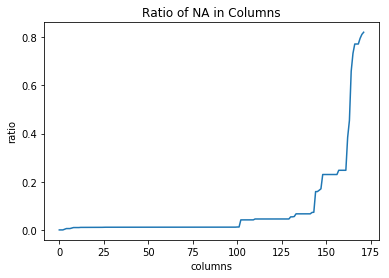

In [96]:
rates = []
for c in df.columns:
    rates.append(sum(df[c].astype(str)=='na')/df[c].count())

# Plot ratio of zeros in columns
plt.figure()
plt.plot(range(len(rates)), sorted(rates))
plt.xlabel("columns")
plt.ylabel("ratio")
plt.title("Ratio of NA in Columns")

As we can seen from above plots, keep ratio at 33% can save most columns.

### Remove columns that missing values > 33%
We use feature-sise deletion method.
Instead of removing rows of X (list-wise), we can remove columns of X (feature-wise)
A general guideline would be if a feature is missing more than 33%

In [97]:
def drop_33_na(df):
    del_col = []
    for c in df.columns:
        if df[c].dtype==object and sum(df[c]=='na')/df[c].count() > 0.33:
            del_col.append(c)
    df = df.drop(columns = del_col)
    return df

df_join = drop_33_na(df_join)
df_join.replace("na", float("nan"), inplace=True)
df_join = df_join.astype(float)

df_join.shape

(76001, 160)

### Using boxcox for normality transfromation before outliers imputation

In [99]:
#normality

df_join2 = df_join+1
from scipy.stats import boxcox
df_join2.loc[:,:] = boxcox(df_join, lmbda=0.0)

ValueError: Data must be positive.

### Remove outlier using ZScore and quantile range outlier method. 
After removing outlier, the F1 score is low, so we decided to keep outliers.

In [100]:
def remove_zscore_outlier(df):
    zscore = (df - df.mean())/df.std()
    df[zscore>3] = float("nan")
    return df

def remove_iqr_outlier(df):
    q1, q3 = df.quantile(0.25), df.quantile(0.75)
    iqr = q3-q1
    l_fence, u_fence = q1 - 1.5*iqr , q3 + 1.5*iqr
    outliers = (df<l_fence) | (df>u_fence)
    df[outliers] = float("nan")
    return df

df_join3 = remove_zscore_outlier(df_join)
df_join3 = remove_iqr_outlier(df_join)

### Impute missing value
Calculate skewness for the remaining columns 
If the skewness is between -1 and 1, then use “mean” method to impute the missing value
If the skewness is greater than 1 or smaller -1, then use “median”


In [101]:
def fill_missing(df):

    for c in df.columns:
        if abs(df[c].skew(skipna=True)) < 1:
            df[c].fillna(df[c].mean(), inplace = True)
        else:
            df[c].fillna(df[c].median(), inplace = True)
    return df

df_join = fill_missing(df_join)

### Plot the ratio of zeros in columns
We want to see if there are too many 0 in columns to decide whether we need to delete that column or not.

In [102]:
# compute p(t=1, x!=0)/p(x!=0)
true_pos = []
for c in df_join.columns:
    col = df_join[c]
    p11= ((df["target"] == 1) &(col != 0) ).mean()
    p_1= (col != 0 ).mean()
    true_pos.append(p11/(p_1))
# compute number of zeros
rate =[]
for c in df_join.columns:
    rate_0 = (df_join[c] == 0).mean()
    rate.append(rate_0)

/Users/yifan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Text(0, 0.5, 'ratio')

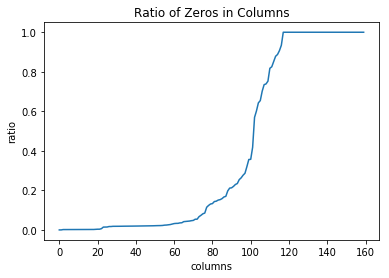

In [103]:
plt.figure()
plt.plot(range(len(rate)), sorted(rate))
plt.title("Ratio of Zeros in Columns")
plt.xlabel("columns")
plt.ylabel("ratio")

### Exploring relationships between columns with many 0s and target.
we want to see if too many columnns with 0s have strong relationship with target, then we would remove these columns. However, from the chart above, we can see that the relationship is not strong, so we preserve these columns.

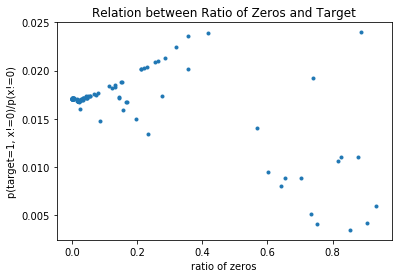

In [104]:
plt.figure()
plt.plot(rate, true_pos, '.')
plt.title("Relation between Ratio of Zeros and Target")
plt.xlabel("ratio of zeros")
plt.ylabel("p(target=1, x!=0)/p(x!=0)")
plt.show()

But we decided to keep all columnns even if it has too many 0s. The reason can be seen from the "Relation between Ratio of Zeros and Target" plot below.

### Normalizing data set using (Xi - mean(X))/ max(X) - min(X)

In [105]:
max_min = df_join.max()-df_join.min()
df_join = (df_join-df_join.mean())/max_min
df_join = df_join.loc[:,max_min!=0]

### Saving data files after cleaning

In [39]:
df_train = df_join.iloc[:60000]
df_test = df_join.iloc[60000:]

In [107]:
df_train.to_csv("training_X_norm.csv", index=False)
df_test.to_csv("test_X_norm.csv", index=False)

### Random Forests

In [108]:
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

train_X = pd.read_csv("training_X_norm.csv")
train_y = pd.read_csv("training_y.csv")['target']
test_X = pd.read_csv("test_X_norm.csv")

for i in range(10):
    X_train, X_validate, y_train, y_validate = train_test_split(train_X, train_y)

    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_train,y_train)
    print(f1_score(y_validate, clf.predict(X_validate)))




FileNotFoundError: File b'training_y.csv' does not exist

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

train_X = pd.read_csv("training_X_norm.csv")
train_y = pd.read_csv("training_y.csv")['target']
test_X = pd.read_csv("test_X_norm.csv")

for i in range(0):
    X_train, X_validate, y_train, y_validate = train_test_split(train_X, train_y)
    rf1 = RandomForestClassifier(n_estimators=20)
    rf2 = RandomForestClassifier(n_estimators=20)
    svc = SVC(gamma=0.1)
    lr  = LogisticRegression(solver="lbfgs")

    keep = np.random.random(len(X_train))<0.3
    X_train_svc = X_train[keep | y_train == 1]
    y_train_svc = y_train[keep | y_train == 1]

    keep = np.random.random(len(X_train))<0.1
    X_train_nn = X_train[keep | y_train == 1]
    y_train_nn = y_train[keep | y_train == 1]
    
    rf1.fit(X_train, y_train)
    rf2.fit(X_train, y_train)
    svc.fit(X_train_svc, y_train_svc)
    lr.fit(X_train, y_train)
    #nn.fit(X_train_nn,y_train_nn)

    pred_train = {}
    pred_validate = {}
    for i, clf in enumerate([rf1, rf2, svc, lr]):
        pred_train[i] = clf.predict(X_train)
        pred_validate[i] = clf.predict(X_validate)
        
    pred_train = pd.DataFrame(pred_train)
    pred_validate = pd.DataFrame(pred_validate)
    meta_rf = RandomForestClassifier(n_estimators=10)
    meta_rf.fit(pred_train,y_train)
    print(f1_score(y_validate, meta_rf.predict(pred_validate)))

rf1 = RandomForestClassifier(n_estimators=20)
rf2 = RandomForestClassifier(n_estimators=20)
svc = SVC(gamma=0.1)
lr  = LogisticRegression(solver="lbfgs")

keep = np.random.random(len(train_X))<0.3
train_X_svc = train_X[keep | train_y == 1]
train_y_svc = train_y[keep | train_y == 1]

rf1.fit(train_X, train_y)
rf2.fit(train_X, train_y)
svc.fit(train_X_svc, train_y_svc)
lr.fit(train_X, train_y)

pred_train = {}
pred_test = {}
for i, clf in enumerate([rf1, rf2, svc, lr]):
    pred_train[i] = clf.predict(train_X)
    pred_test[i] = clf.predict(test_X)
    
pred_train = pd.DataFrame(pred_train)
pred_test = pd.DataFrame(pred_test)
meta_rf = RandomForestClassifier(n_estimators=100)
meta_rf.fit(pred_train, train_y)
#print(f1_score(y_validate, meta_rf.predict(pred_validate)))
test_y = meta_rf.predict(pred_test)
prediction = pd.DataFrame({"id":range(1, len(test_X)+1), "target":test_y})
prediction.to_csv("final_prediction.csv", index=False)